In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import pickle
import yaml
from mist.utils.plot_utils import *
from itertools import product
from tqdm import tqdm
import umap

from mist.utils import analysis_utils 
from mist.data import featurizers

from matplotlib.patches import Patch, Rectangle
from matplotlib.lines import Line2D
import matplotlib.ticker as mtick
from collections import Counter

# reload analysis_utils
from importlib import reload
reload(analysis_utils)

set_style()

/home/samlg/.conda/envs/ms-gen/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-09-01 11:47:45.864362: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-01 11:47:46.367611: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
out_folder = Path("../results/figures/csi_embed_compare/")
out_folder.mkdir(parents=True, exist_ok=True)

res_dicts = {"mist": "../results/csi_dist_compare/mist_csi2022_split_0.p",
             "cosine": "../results/csi_dist_compare/cosine_csi2022_split_0.p",
             "ms2deepscore": "../results/csi_dist_compare/ms2deepscore_csi2022_split_0.p",
             "spec2vec": "../results/csi_dist_compare/spec2vec_csi2022_split_0.p",
             "tanimoto": "../results/csi_dist_compare/tanimoto_csi2022_split_0.p",
             "random": "../results/csi_dist_compare/random_csi2022_split_0.p",
    }

In [3]:
all_res = {}
for k, v in res_dicts.items():
    all_res[k] = pickle.load(open(v, "rb"))

In [4]:
labels = "../data/paired_spectra/csi2022/labels.tsv"
split_0 = "../data/paired_spectra/csi2022/splits/csi_split_0.tsv"
labels_df = pd.read_csv(labels, sep="\t")
name_to_smi = dict(zip(labels_df['spec'], labels_df['smiles']))

split_0 = pd.read_csv(split_0, sep="\t")
test_names = set(split_0[split_0['split'] == "test"]['name'].values)
test_names = list(test_names)

## Tanimoto distance plot

In [5]:
# Note in paper, we used radius 3 fingerprints, accounting for the difference.
featurizer = featurizers.FingerprintFeaturizer(fp_names=["morgan2048"])
test_fps = [featurizer.featurize_smiles(name_to_smi[i]) for i in test_names]
test_fps = np.vstack(test_fps)

In [6]:
# Compute tani sim

intersect = np.einsum("ij,kj->ik", test_fps, test_fps)
union = test_fps.sum(-1)[None, :] + test_fps.sum(-1)[:, None] - intersect
tani_sim = intersect / union
# Create dict of all pairs
pair_dict = {}
for ind1, i in enumerate(tqdm(test_names)):
    for ind2, j in enumerate(test_names):
        pair_dict[(i, j)] = tani_sim[ind1, ind2]
        pair_dict[(j, i)] = tani_sim[ind2, ind1]

100%|██████████| 6233/6233 [00:43<00:00, 144.57it/s]


In [44]:
max_len = int(0.001 * len(test_names) * len(test_names))
interval = 20
x = np.arange(1, max_len)[interval::interval]
x_plot = x/ len(test_names) / len(test_names) * 100

In [45]:
for _, res in all_res.items():
    top_tani = [pair_dict[j] for j in res['top_pairs_sorted']]
    top_tani = [np.mean(top_tani[:j]) for j in x]
    res['top_tani'] = top_tani[:]

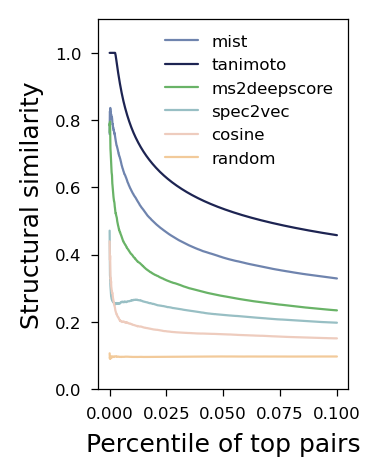

In [46]:
ax_figsize = (1.25, 1.85)
fig = plt.figure(figsize=(ax_figsize), dpi=200)
ax = fig.gca()
for model in color_scheme:
    if model not in all_res:
        continue
    y = all_res[model]['top_tani']
    color = color_scheme[model]
    ax.plot(x_plot,y, label=model, linewidth=0.8, color=color)

ax.set_xlabel("Percentile of top pairs")
ax.set_ylabel("Structural similarity")
ax.set_ylim([0,1.1])
ax.legend(frameon=False, facecolor="none", fancybox=False)
set_size(*ax_figsize)
save_name = out_folder / "tani_lineplot.pdf"
fig.savefig(save_name, bbox_inches="tight", dpi=400, transparent=True)


## UMAP

In [10]:
save_name = out_folder / "umap.png"
embed_outs = "../results/csi_dist_compare/mist_embed/embed_csi2022.p"
embeddings = pickle.load(open(embed_outs, "rb"))
embed_ar = embeddings['embeds']
embed_names = embeddings['names']

In [11]:
# Lower min dist and lwoer n neighbors makes it a ltitle more clumped
reducer = umap.UMAP(metric="cosine", min_dist=0.1, n_neighbors=15, spread=1.0, random_state=42)
umap_embeds = reducer.fit_transform(
    embed_ar,
)

In [12]:
cls_annots = "../results/dataset_analyses/csi2022/smi_to_classes.p"
cls_annots = pickle.load(open(cls_annots, "rb"))

In [13]:
classes = []
for name in embed_names:
    superclasses = cls_annots[name]["superclass_results"]
    if len(superclasses) == 0:
        classes.append("Unknown")
    else:
        classes.append(np.random.choice(superclasses))
embed_classes = np.array(classes)

In [14]:
# Resort to organize
plot_groups = [
    "Unknown",
    "Oligopeptides",
    "Small peptides",
    "Lysine alkaloids",
    "Tyrosine alkaloids",
    "Tryptophan alkaloids",
    "Nicotinic acid alkaloids",
    "Anthranilic acid alkaloids",
    "Ornithine alkaloids",
    "Pseudoalkaloids",
    "Flavonoids",
    "Coumarins",
    "Steroids",
    "Triterpenoids",
    "Sesquiterpenoids",
]
# Build colors
colors = sns.color_palette("husl", n_colors=len(plot_groups))

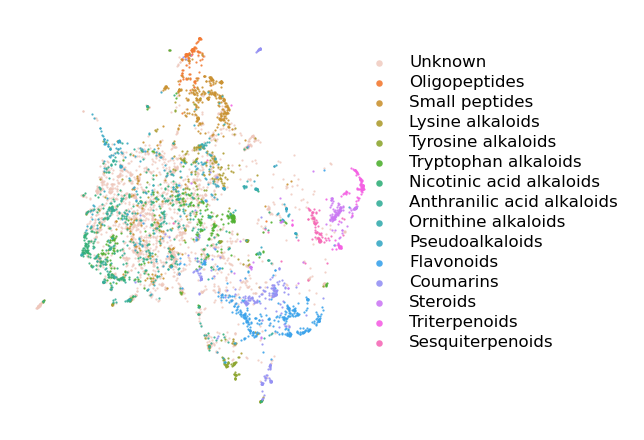

In [16]:
ax_size = (1.8, 2.0)

fig = plt.figure(figsize=ax_size, dpi=200)
ax = fig.gca()
for ind, cls_name in enumerate(plot_groups):
    color = colors[ind]
    inds = np.where(embed_classes  == cls_name)[0]
    out = ax.scatter(
        umap_embeds[inds, 0],
        umap_embeds[inds, 1],
        label=cls_name,
        facecolors=color if cls_name != "Unknown" else "#EFC7BB", 
        edgecolors=color if cls_name != "Unknown" else "#EFC7BB", 
        s=0.6,
        linewidth=0.01,
        alpha=0.9 if cls_name !=  "Unknown" else 0.8,
    )

ax.legend(
    loc="upper left",
    frameon=False,
    facecolor="none",
    fancybox=False,
    markerscale=3,
    bbox_to_anchor=(0.91, 0.95),
    labelspacing=0.3,
    # bbox_to_anchor=(-0.5, 0.95)  , #
    ncol=1,
)
ax.set_xticks([])
ax.set_yticks([])
# ax.set_xlabel("UMAP 1")
# ax.set_ylabel("UMAP 2")
ax.axis("off")
set_size(*ax_size)
fig.savefig(save_name, bbox_inches="tight", dpi=400, transparent=True)